# Classification.ipynb
Date: November 29th, 2018  
Course: ECSE415, McGill University  
Authors:  
*Shawn Vosburg  
Tristan Bouchard  
Alex Masciotra  
Nayem Alam  
Thomas Philippon *

## NOTE: The classification files folder must be found in the same folder as this code. 

In [5]:
#Import necessary libraries. Strategy: Find HoG features of each image and build SVM with them.
#For second classifier, try Kmeans or Kneighboors
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import  random as rand
from sklearn import svm
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


#from sklearn.neighbors import KNeighborsClassifier

#Declare Constants
CLASSIFY_DIM = (128,128)   #Size of the training images
KCROSSVALID_NUM = 10       #Number of bins when doing k-cross validation
IMGMAXPERCAT = 2200        #We take max  of the images. This is to reduce computation time. 

#Make directories if necessary
if(not os.path.isdir("./Classifiers/SVM/")):
    os.makedirs("./Classifiers/SVM/")
if(not os.path.isdir("./Classifiers/Kneigh/")):
    os.makedirs("./Classifiers/Kneigh/")
if(not os.path.isdir("./bin/")):
    os.makedirs("./bin/")

## 2. Classification
### Loading and resizing images && Compute HOG features of all images.

In [6]:
def HoGFromImage(img,cs,bs,nb):
    """ This function takes in an image array and HoG param and returns the computed histogram for the image array
        img = image array. all images must be same resolution. 
        cs = cell size in pixel x pixel (height x width)
        bc = bin size in cell x cell (height x width)
        nb = number of bins

    """

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cs[1] * cs[1],
                                      img.shape[0] // cs[0] * cs[0]),
                            _blockSize=(bs[1] * cs[1],
                                        bs[0] * cs[0]),
                            _blockStride=(cs[1], cs[0]),
                            _cellSize=(cs[1], cs[0]),
                            _nbins=nb)
    
    
    n_cells = (img.shape[0] // cs[0], img.shape[1] // cs[1])
        

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - bs[1] + 1,
                            n_cells[0] - bs[0] + 1,
                            bs[0], bs[1], nb) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    #Add each contributions to the histogram.
    for off_y in range(bs[0]):
        for off_x in range(bs[1]):
            gradients[off_y:n_cells[0] - bs[0] + off_y + 1,
                      off_x:n_cells[1] - bs[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - bs[0] + off_y + 1,
                       off_x:n_cells[1] - bs[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

#Create function to save classifier
def saveCLF(clf,path):
    joblib.dump(clf,path)
    
#Create function to load classifier
def loadCLF(path):
    return joblib.load(path)

#Class to hold the feature data and the label
class labeledData():
    def __init__(self,data,label,num):
        self.data = data
        self.label = label
        self.num = num

In [7]:
#Import training images
folder = "./MIO-TCD-Classification/train/"
vehicleName = [
    "articulated_truck", "background", "bicycle",
    "bus", "car", "motorcycle", "non-motorized_vehicle",
    "pedestrian", "pickup_truck", "single_unit_truck", "work_van"                
]
vehicleDir  = [                                  #Main Directory of Training images
     "articulated_truck",        #10346 imgs
     "background",               #160000 imgs
     "bicycle",                  #2284 imgs
     "bus",                      #10316 imgs
     "car",                      #260518 imgs
    "motorcycle",               #1982 imgs
    "non-motorized_vehicle",    #1751 imgs
    "pedestrian",               #6262 imgs
    "pickup_truck",             #50906 imgs
    "single_unit_truck",        #5120 imgs
    "work_van"                 #9679 imgs
]                 

vehicleTypes = {}                                #This is the main hash that will map the vehicles type to a number. Maps string to index.
vehicleImgArr,vehicleLabels,hogArr = [],[],[]
idx = 0

#Build Hash Table
for bucket in os.listdir(folder):
    vehicleTypes[bucket] = idx
    idx +=1

#HOG features parameters
cell_size = (8,8)  # h x w in pixels 
block_size = (2,2)  # h x w in cells
nbins = 8  # number of orientation bins

#Loop across directory to fetch all images
savingPath = "./bin/ImgArr.data"
start = time.time()
if(not os.path.isfile(savingPath)):
    for typeName in vehicleDir:
        vehicleTypeDir = folder + typeName+"/"
        print("Presently loading & finding HOG features of " + str(min(len(os.listdir(vehicleTypeDir)),IMGMAXPERCAT)) + " images from: " + typeName,end="")
        presentTime = time.time()

        #fetch images
        idx = 0
        for imgPath in os.listdir(vehicleTypeDir):
            if(idx >= IMGMAXPERCAT):
                break
            img = cv2.imread(vehicleTypeDir+imgPath)
            img = cv2.resize(img,CLASSIFY_DIM)                          #Resize images so that they are all CLASSIFY_DIM in size
            #vehicleImgArr.append(img)                                  #Commented this out to save processing time. 
            vehicleLabels.append(vehicleTypes[typeName])                #Have a seperate array with the labels.
            hogArr.append(HoGFromImage(img,cell_size,block_size,nbins)) #Find Hog Features
            idx += 1
            
        endTime = time.time()
        print(". (Time taken: ", endTime - presentTime,"secs)")
    hogArr = np.asarray(hogArr)
    vehicleLabels = np.asarray(vehicleLabels)
    
    #Saving files:
    print("Saving...",end = "")
    savingPath = "./bin/ImgArr.data"      #Img Data
    joblib.dump(vehicleImgArr,savingPath)
    savingPath = "./bin/HogArr.data"      #Hog Arr
    joblib.dump(hogArr,savingPath)
    savingPath = "./bin/LabelsArr.data"      #labels Arr
    joblib.dump(vehicleLabels,savingPath)
    print("DONE!")
else:
    print("Presently loading saved binary of images/HOG features and labels ...",end = "")
    savingPath = "./bin/ImgArr.data"      #Img Data
    vehicleImgArr = joblib.load(savingPath)
    savingPath = "./bin/HogArr.data"      #Hog Arr
    hogArr = joblib.load(savingPath)
    savingPath = "./bin/LabelsArr.data"      #labels Arr
    vehicleLabels = joblib.load(savingPath)
    print("DONE!")
end = time.time()

#Print out report:
print("REPORT: \n\tTotal Number of images:",len(hogArr),"\n\tTotal time taken: ",end-start,"sec")


Presently loading saved binary of images/HOG features and labels ...DONE!
REPORT: 
	Total Number of images: 23533 
	Total time taken:  0.6511495113372803 sec


#### Preview of Image and its HOG features

Example of  pedestrian  hog features:


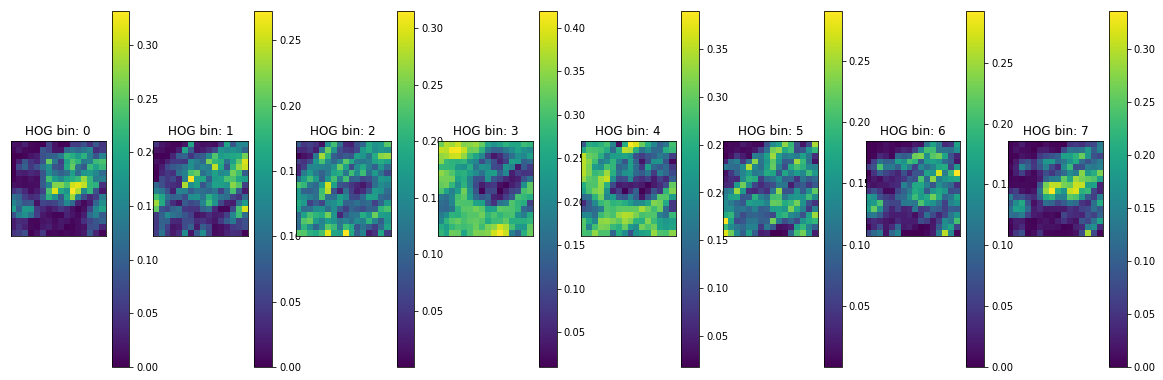

In [8]:
# Preview image and its hog features
preview = 16500
print("Example of ",vehicleName[vehicleLabels[preview]]," hog features:")
plt.figure(figsize = (20,20))
for bin in range(nbins):
    plt.subplot(181+bin)
    plt.pcolor(hogArr[preview][:, :, bin%nbins])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    title = "HOG bin: " +  str(bin%nbins)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

**Discussion:**  
All images HOG features are computed-&-loaded inside *hogArr*. The features that are calculted are of size (16,16,8) meaning that for 8 angular directions, 16x16 array of hog features were calculated for each images (see above for the preview of what sample image with its hog features look like). Therefore, for each image, features of size $16^2 * 8 = 2048$ are calculated. 

## Classifier #1: SVM
#### Creating classifier

In [9]:
#Building filepath
savingPath = "./Classifiers/SVM/"
clfFileType = ".clf"
name = "SVMclf"+ "_Main"
path = savingPath + name +clfFileType

#Build classifier if it doesn't already exist
if(not os.path.isfile(path)):
    #Creating main classifier that is trained with all training images. 
    dataSVM = hogArr.reshape(len(hogArr),-1)
    labelsSVM = vehicleLabels.reshape(-1)

    #Train SVM classifier
    print("Building the main SVM classifier ...",end = '')
    pTime = time.time()
    clfMain = svm.SVC(C=100.) 
    clfMain.fit(dataSVM, labelsSVM)
    eTime = time.time()
    print("DONE!")
    print("Time taken to build main SVM classifier:",eTime-pTime,"sec")

    #Saving main SVM classifier
    saveCLF(clfMain,path)

#If the file already exist, just load the classifier instead of building a new one (saves a lot of time)
else:
    print("Loading main SVM classifier ...",end = '')
    clfMain = loadCLF(path)
    print("DONE!")

Loading main SVM classifier ...DONE!


**Discussion:**  
In order to avoid always rebuilding the same classifier everytime, logic has been added to load an already saved version of the calssifier. The main SVM classifier is saved as *./Classifiers/SVM/SVMclf_Main.clf*. To build a new classifier, please delete that file before running the jupyter cell above. 

## Classifier #2:  K-NearestNeighbor

In [10]:
#Building filepath
savingPath2 = "./Classifiers/Kneigh/"
clfFileType2 = ".clf"
name2 = "Kneighclf"+ "_Main"
path2 = savingPath2 + name2 +clfFileType2

#Build classifier if it doesn't already exist
if(not os.path.isfile(path2)):
    #Creating main classifier that is trained with all training images. 
    dataKneigh = hogArr.reshape(len(hogArr),-1)
    labelsKneigh = vehicleLabels.reshape(-1)

    #Train Kneigh classifier
    print("Building the main Kneigh classifier ...",end = '')
    pTime = time.time()
    clfMain2 = KNeighborsClassifier(n_neighbors=len(vehicleDir))
    clfMain2.fit(dataKneigh, labelsKneigh)
    eTime = time.time()
    print("DONE!")
    print("Time taken to build main Kneigh classifier:",eTime-pTime,"sec")

    #Saving main SVM classifier
    saveCLF(clfMain2,path2)

#If the file already exist, just load the classifier instead of building a new one (saves a lot of time)
else:
    print("Loading main Kneigh classifier ...",end = '')
    clfMain2 = loadCLF(path2)
    print("DONE!")

Loading main Kneigh classifier ...DONE!


## 2.1 Classifier evaluation
### 2.1.1 Evaluating SVM

#### Creating k-bin classifiers

In [11]:
#USING K-CROSSVALIDATION
#BUILDING ARRAY OF SIZE K WITH ALL K-CLASSIFIERS 

#Reshape the data to be a NxD array
data = hogArr.reshape(len(hogArr),-1)
labels = vehicleLabels.reshape(len(vehicleLabels),-1)

#create labeled data for shuffling if it isn't already saved; else used saved and already shuffled version
savingPath = "./bin/"
dataFileType = ".data"
name = "labeledData_Validation" + str(KCROSSVALID_NUM)
path = savingPath +name+ dataFileType
if(not os.path.isfile(path)):
    #Create a randomized array 
    print("Shuffling labeled data ...",end = '')
    dataAndLabel = [labeledData(data[i],labels[i],i) for i in range(len(data))]
    dataAndLabel = np.asarray(dataAndLabel) 
    rand.shuffle(dataAndLabel)
    print("DONE!")
    print("Saving labeled data ...",end = '')
    joblib.dump(dataAndLabel,path)
    print("DONE!")
else:
    print("Loading labeled data ...",end = '')
    dataAndLabel = joblib.load(path)
    print("DONE!")
    
#split data into training and testing arrays
k = KCROSSVALID_NUM
sizeOfBin = len(dataAndLabel) // k
savingPath = "./Classifiers/SVM/"
clfFileType = ".clf"
clfArr = []
for kIdx in range(k):
    name = "SVMclf_Validation"+ str(kIdx)
    path = savingPath +name+ clfFileType
    #Only create a new classifier if it hasn't been built before (implemented as such because they take a long time to generate)
    if(not os.path.isfile(path)):
        #Creating Training Array
        labeledTrain = np.delete(dataAndLabel,np.arange(kIdx*sizeOfBin,(kIdx+1)*sizeOfBin))  #Size of (k-1)*sizeOfBin
        Train = [labeledTrain[i].data for i in range(len(labeledTrain))]
        Train = np.asarray(Train)
        TrainLabel= [labeledTrain[i].label for i in range(len(labeledTrain))]
        TrainLabel = np.asarray(TrainLabel).reshape(-1)

        #Train SVM classifier
        print("Building SVM classifier for testing k-bin =",kIdx,"...",end = '')
        pTime = time.time()
        clf = svm.SVC(gamma=0.001, C=100.)
        clf.fit(Train, TrainLabel)
        clfArr.append(clf)
        eTime = time.time()
        print("DONE!",end = " ")
        print("(Time taken to build classifier",kIdx,":",eTime-pTime,"sec)")

        #Saving SVM Classifier
        name = "SVMclf_Validation"+ str(kIdx)
        path = savingPath +name+ clfFileType
        saveCLF(clf,path)
    
    #If classifier already exist, just print a statement saying it already exist
    else:
        print("Loading existing SVM classifier for k-bin =", kIdx, "...",end="")
        pTime = time.time()
        clfArr.append(loadCLF(path))
        eTime = time.time()
        print("DONE!",end = " ")
        print("(Time taken to load classifier",kIdx,":",eTime-pTime,"sec)")
        


Loading labeled data ...DONE!
Loading existing SVM classifier for k-bin = 0 ...DONE! (Time taken to load classifier 0 : 7.180274486541748 sec)
Loading existing SVM classifier for k-bin = 1 ...DONE! (Time taken to load classifier 1 : 7.398269176483154 sec)
Loading existing SVM classifier for k-bin = 2 ...DONE! (Time taken to load classifier 2 : 6.01653790473938 sec)
Loading existing SVM classifier for k-bin = 3 ...DONE! (Time taken to load classifier 3 : 8.061376571655273 sec)
Loading existing SVM classifier for k-bin = 4 ...DONE! (Time taken to load classifier 4 : 8.206270217895508 sec)
Loading existing SVM classifier for k-bin = 5 ...DONE! (Time taken to load classifier 5 : 9.20791745185852 sec)
Loading existing SVM classifier for k-bin = 6 ...DONE! (Time taken to load classifier 6 : 8.596079111099243 sec)
Loading existing SVM classifier for k-bin = 7 ...DONE! (Time taken to load classifier 7 : 7.879503965377808 sec)
Loading existing SVM classifier for k-bin = 8 ...DONE! (Time taken t

#### Predicting labels

In [12]:
#Setting important variables
loadingPath = "./bin/"
clfFileType = ".clf"
dataFileType = ".data"
k = KCROSSVALID_NUM
sizeOfBin = len(dataAndLabel) // k

#loading randomized labeled data that was used to train classifiers. Used to make sure that training images aren't used for testing
path = loadingPath + "labeledData_Validation" + str(k) + dataFileType
dataAndLabel = joblib.load(path)

#Predicting the Test data
accuracyArr = []
predictedArr = []
TestLabelArr = []
confusionPredArr = np.asarray([])
confusionActualArr = np.asarray([])
for kIdx in range(k):
    #Loading K-cross validation classifier
    clf = clfArr[kIdx]
    
    #Building test arrays
    labeledTest  = dataAndLabel[kIdx*sizeOfBin:(kIdx+1)*sizeOfBin]  #Size of sizeofBin
    Test = [labeledTest[i].data for i in range(len(labeledTest))]
    Test = np.asarray(Test)
    TestLabel= [labeledTest[i].label for i in range(len(labeledTest))]
    TestLabel = np.asarray(TestLabel).reshape(-1)
    
    #Predicting the test array
    print("Predicting labels of Test images from k-bin =",kIdx,"...",end = '')
    start = time.time()
    predicted = clf.predict(Test)
    end = time.time()
    print("DONE!", end = " ")
    print("(Time taken to predict images: ",end-start,"sec)")
    
    predictedArr.append(predicted)
    TestLabelArr.append(TestLabel)


Predicting labels of Test images from k-bin = 0 ...DONE! (Time taken to predict images:  187.2030918598175 sec)
Predicting labels of Test images from k-bin = 1 ...DONE! (Time taken to predict images:  180.15715432167053 sec)
Predicting labels of Test images from k-bin = 2 ...DONE! (Time taken to predict images:  179.62571620941162 sec)
Predicting labels of Test images from k-bin = 3 ...DONE! (Time taken to predict images:  178.6839940547943 sec)
Predicting labels of Test images from k-bin = 4 ...DONE! (Time taken to predict images:  178.8487424850464 sec)
Predicting labels of Test images from k-bin = 5 ...DONE! (Time taken to predict images:  182.70469450950623 sec)
Predicting labels of Test images from k-bin = 6 ...DONE! (Time taken to predict images:  178.71703624725342 sec)
Predicting labels of Test images from k-bin = 7 ...DONE! (Time taken to predict images:  180.62722849845886 sec)
Predicting labels of Test images from k-bin = 8 ...DONE! (Time taken to predict images:  181.445789

#### Finding TP,TN,FP,FN

In [13]:
#Find TP,TN,FP,FN for each label
flatPredicted = np.asarray(predictedArr)
flatTestLabel = np.asarray(TestLabelArr)
Flags  = np.zeros((len(vehicleDir),KCROSSVALID_NUM ,4)) #Every categories have TP,TN,FP,FN

for pred in range(KCROSSVALID_NUM):
    for i in range(len(flatPredicted[pred])):
        predLabel = flatPredicted[pred][i]
        actualLabel = flatTestLabel[pred][i]
        for j in range(len(vehicleDir)):
            #Find TP
            if(j == actualLabel and j == predLabel):
                Flags[j][pred][0] += 1

            #Find TN
            if(j != actualLabel and j != predLabel):
                Flags[j][pred][1] += 1

            #Find FP
            if(j != actualLabel and j == predLabel):
                Flags[j][pred][2] += 1

            #FIND FN
            if(j == actualLabel and j != predLabel):
                Flags[j][pred][3] += 1


#### Evaluating SVM classifier
#### Average classification accuracy across validations, with the standard deviation.

In [14]:
#Finding accuracy
accuracy = np.zeros(len(vehicleDir))
for k in range(len(vehicleDir)):
    for pred in range(KCROSSVALID_NUM):
        accuracy[k] += (Flags[k][pred][0] +Flags[k][pred][1])/sum(Flags[k][pred])/KCROSSVALID_NUM

#Creating report of accuracy of all validations
for k in range(len(vehicleDir)):
    print("REPORT ACCURACY for ",vehicleDir[k],": ")
    print("\tAccuracy:", accuracy[k])

#Print total report
print("\nREPORT ACCURACY CLASSIFIER: ")
print("\tAccuracy:", np.mean(accuracy))
print("\tStandard Deviation:",np.std(accuracy))


REPORT ACCURACY for  articulated_truck : 
	Accuracy: 0.9180620484487889
REPORT ACCURACY for  background : 
	Accuracy: 0.9404164895877603
REPORT ACCURACY for  bicycle : 
	Accuracy: 0.9375265618359541
REPORT ACCURACY for  bus : 
	Accuracy: 0.9457713557161072
REPORT ACCURACY for  car : 
	Accuracy: 0.9487462813429667
REPORT ACCURACY for  motorcycle : 
	Accuracy: 0.9373140671483213
REPORT ACCURACY for  non-motorized_vehicle : 
	Accuracy: 0.9303867403314917
REPORT ACCURACY for  pedestrian : 
	Accuracy: 0.9396515087122823
REPORT ACCURACY for  pickup_truck : 
	Accuracy: 0.9415214619634509
REPORT ACCURACY for  single_unit_truck : 
	Accuracy: 0.9286867828304293
REPORT ACCURACY for  work_van : 
	Accuracy: 0.9363790905227369

REPORT ACCURACY CLASSIFIER: 
	Accuracy: 0.9367693080400262
	Standard Deviation: 0.008122500420946534


#### Average precision* and recall* across validations. Are these values consistent with the accuracy? Are they more representative of the dataset? In what situations would you expect precision and recall to be a better reflection of model performance than accuracy?

In [15]:
#Finding precision and recall
precision = np.zeros(len(vehicleDir))
recall = np.zeros(len(vehicleDir))
for k in range(len(vehicleDir)):
    for pred in range(KCROSSVALID_NUM):
        precision[k] += (Flags[k][pred][0])/(Flags[k][pred][0] + Flags[k][pred][2]) / KCROSSVALID_NUM
        recall[k] += (Flags[k][pred][0])/(Flags[k][pred][0] + Flags[k][pred][3]) / KCROSSVALID_NUM

#Creating report of precision and recall of all validations
for k in range(len(vehicleDir)):
    print("REPORT PRECISION/RECALL for ",vehicleDir[k],": ")
    print("\tPRECISION:", precision[k])
    print("\tRECALL:", recall[k])

#Print total report
print("\nREPORT PRECISION/RECALL CLASSIFIER: ")
print("\tPRECISION:", np.mean(precision))
print("\tRECALL:",np.mean(recall))


REPORT PRECISION/RECALL for  articulated_truck : 
	PRECISION: 0.554579415876026
	RECALL: 0.628887618900965
REPORT PRECISION/RECALL for  background : 
	PRECISION: 0.6618359117220118
	RECALL: 0.7407037606297333
REPORT PRECISION/RECALL for  bicycle : 
	PRECISION: 0.6689726689015031
	RECALL: 0.6583265146437808
REPORT PRECISION/RECALL for  bus : 
	PRECISION: 0.7004518559212999
	RECALL: 0.7345793087409662
REPORT PRECISION/RECALL for  car : 
	PRECISION: 0.7153876192860508
	RECALL: 0.7490917061331143
REPORT PRECISION/RECALL for  motorcycle : 
	PRECISION: 0.6240764289125932
	RECALL: 0.6497926497758522
REPORT PRECISION/RECALL for  non-motorized_vehicle : 
	PRECISION: 0.5332456032506171
	RECALL: 0.5115039185975041
REPORT PRECISION/RECALL for  pedestrian : 
	PRECISION: 0.6835705143350767
	RECALL: 0.6619770402076018
REPORT PRECISION/RECALL for  pickup_truck : 
	PRECISION: 0.6961136712570649
	RECALL: 0.6667449751259749
REPORT PRECISION/RECALL for  single_unit_truck : 
	PRECISION: 0.6460591756361548


#### A confusion matrix on a validation set. Plot the matrix as an image. Are any of the classes difficult for your classifier? Discuss. 

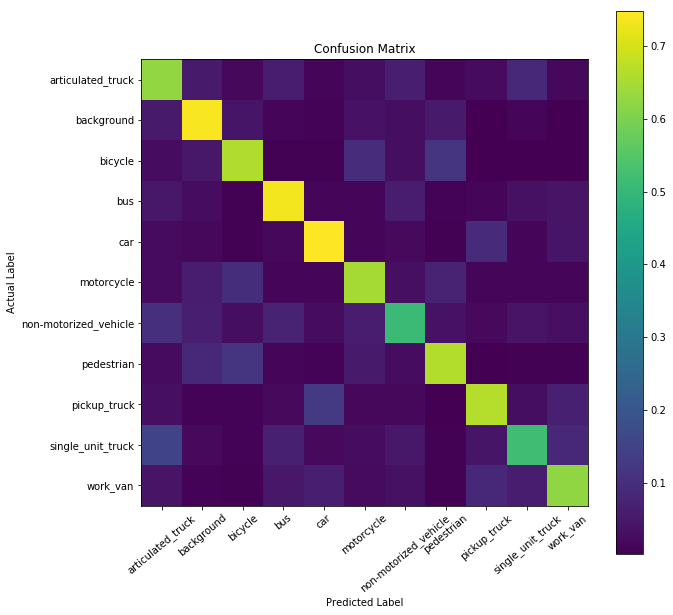

In [16]:
#Create ConfusionArrays
confusionPredArr = np.asarray(predictedArr).reshape(-1)
confusionActualArr = np.asarray(TestLabelArr).reshape(-1)

#Obtain non-normalize confusion matrix
confusionMat = confusion_matrix(confusionActualArr,confusionPredArr)

#Normalize confusion matrix across rows. 
confusionMat =  confusionMat.astype('float') / confusionMat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (10,10))
plt.imshow(confusionMat)
plt.colorbar()
title = "Confusion Matrix"
plt.title(title), plt.xlabel("Predicted Label"), plt.ylabel("Actual Label")
plt.xticks(np.arange(11),vehicleName,rotation=40), plt.yticks(np.arange(11),vehicleName)
plt.show()

### 2.1.2 Evaluating K-Neighbors

#### Creating k-bin classifiers

In [17]:
#USING K-CROSSVALIDATION
#BUILDING ARRAY OF SIZE K WITH ALL K-CLASSIFIERS 

#Reshape the data to be a NxD array
data = hogArr.reshape(len(hogArr),-1)
labels = vehicleLabels.reshape(len(vehicleLabels),-1)

#create labeled data for shuffling if it isn't already saved; else used saved and already shuffled version
savingPath = "./bin/"
dataFileType = ".data"
name = "labeledData_Validation" + str(KCROSSVALID_NUM)
path = savingPath +name+ dataFileType
if(not os.path.isfile(path)):
    #Create a randomized array 
    print("Shuffling labeled data ...",end = '')
    dataAndLabel = [labeledData(data[i],labels[i],i) for i in range(len(data))]
    dataAndLabel = np.asarray(dataAndLabel) 
    rand.shuffle(dataAndLabel)
    print("DONE!")
    print("Saving labeled data ...",end = '')
    joblib.dump(dataAndLabel,path)
    print("DONE!")
else:
    print("Loading labeled data ...",end = '')
    dataAndLabel = joblib.load(path)
    print("DONE!")
    
#split data into training and testing arrays
k = KCROSSVALID_NUM
sizeOfBin = len(dataAndLabel) // k
savingPath = "./Classifiers/Kneigh/"
clfFileType = ".clf"
clfArr = []
for kIdx in range(k):
    name = "Kneighclf_Validation"+ str(kIdx)
    path = savingPath +name+ clfFileType
    #Only create a new classifier if it hasn't been built before (implemented as such because they take a long time to generate)
    if(not os.path.isfile(path)):
        #Creating Training Array
        labeledTrain = np.delete(dataAndLabel,np.arange(kIdx*sizeOfBin,(kIdx+1)*sizeOfBin))  #Size of (k-1)*sizeOfBin
        Train = [labeledTrain[i].data for i in range(len(labeledTrain))]
        Train = np.asarray(Train)
        TrainLabel= [labeledTrain[i].label for i in range(len(labeledTrain))]
        TrainLabel = np.asarray(TrainLabel).reshape(-1)

        #Train K-neigh classifier
        print("Building Kneigh classifier for testing k-bin =",kIdx,"...",end = '')
        pTime = time.time()
        clf = KNeighborsClassifier(n_neighbors=len(vehicleDir))
        clf.fit(Train, TrainLabel)
        clfArr.append(clf)
        eTime = time.time()
        print("DONE!",end = " ")
        print("(Time taken to build classifier",kIdx,":",eTime-pTime,"sec)")

        #Saving Kneigh Classifier
        name = "Kneighclf_Validation"+ str(kIdx)
        path = savingPath +name+ clfFileType
        saveCLF(clf,path)
    
    #If classifier already exist, just print a statement saying it already exist
    else:
        print("Loading existing Kneigh classifier for k-bin =", kIdx, "...",end="")
        pTime = time.time()
        clfArr.append(loadCLF(path))
        eTime = time.time()
        print("DONE!",end = " ")
        print("(Time taken to load classifier",kIdx,":",eTime-pTime,"sec)")
        


Loading labeled data ...DONE!
Loading existing Kneigh classifier for k-bin = 0 ...DONE! (Time taken to load classifier 0 : 13.888512372970581 sec)
Loading existing Kneigh classifier for k-bin = 1 ...DONE! (Time taken to load classifier 1 : 15.480811595916748 sec)
Loading existing Kneigh classifier for k-bin = 2 ...DONE! (Time taken to load classifier 2 : 14.5684175491333 sec)
Loading existing Kneigh classifier for k-bin = 3 ...DONE! (Time taken to load classifier 3 : 14.140503644943237 sec)
Loading existing Kneigh classifier for k-bin = 4 ...DONE! (Time taken to load classifier 4 : 12.344924688339233 sec)
Loading existing Kneigh classifier for k-bin = 5 ...DONE! (Time taken to load classifier 5 : 13.951621532440186 sec)
Loading existing Kneigh classifier for k-bin = 6 ...DONE! (Time taken to load classifier 6 : 14.582454681396484 sec)
Loading existing Kneigh classifier for k-bin = 7 ...DONE! (Time taken to load classifier 7 : 17.242528676986694 sec)
Loading existing Kneigh classifier f

#### Predicting Labels

In [18]:
#Setting important variables
loadingPath = "./bin/"
clfFileType = ".clf"
dataFileType = ".data"
k = KCROSSVALID_NUM
sizeOfBin = len(dataAndLabel) // k

#loading randomized labeled data that was used to train classifiers. Used to make sure that training images aren't used for testing
path = loadingPath + "labeledData_Validation" + str(k) + dataFileType
dataAndLabel = joblib.load(path)

#Predicting the Test data
accuracyArr = []
predictedArr = []
TestLabelArr = []
confusionPredArr = np.asarray([])
confusionActualArr = np.asarray([])
for kIdx in range(k):
    #Loading K-cross validation classifier
    clf = clfArr[kIdx]
    
    #Building test arrays
    labeledTest  = dataAndLabel[kIdx*sizeOfBin:(kIdx+1)*sizeOfBin]  #Size of sizeofBin
    Test = [labeledTest[i].data for i in range(len(labeledTest))]
    Test = np.asarray(Test)
    TestLabel= [labeledTest[i].label for i in range(len(labeledTest))]
    TestLabel = np.asarray(TestLabel).reshape(-1)
    
    #Predicting the test array
    print("Predicting labels of Test images from k-bin =",kIdx,"...",end = '')
    start = time.time()
    predicted = clf.predict(Test)
    end = time.time()
    print("DONE!", end = " ")
    print("(Time taken to predict images: ",end-start,"sec)")
    
    predictedArr.append(predicted)
    TestLabelArr.append(TestLabel)
    

Predicting labels of Test images from k-bin = 0 ...DONE! (Time taken to predict images:  323.1139256954193 sec)
Predicting labels of Test images from k-bin = 1 ...DONE! (Time taken to predict images:  313.5983831882477 sec)
Predicting labels of Test images from k-bin = 2 ...DONE! (Time taken to predict images:  330.62153244018555 sec)
Predicting labels of Test images from k-bin = 3 ...DONE! (Time taken to predict images:  320.0403962135315 sec)
Predicting labels of Test images from k-bin = 4 ...DONE! (Time taken to predict images:  316.76954412460327 sec)
Predicting labels of Test images from k-bin = 5 ...DONE! (Time taken to predict images:  309.1383948326111 sec)
Predicting labels of Test images from k-bin = 6 ...DONE! (Time taken to predict images:  308.66031098365784 sec)
Predicting labels of Test images from k-bin = 7 ...DONE! (Time taken to predict images:  4734.03059220314 sec)
Predicting labels of Test images from k-bin = 8 ...DONE! (Time taken to predict images:  327.991194248

#### Finding TP,TN,FP,FN

In [19]:
#Find TP,TN,FP,FN for each label
flatPredicted = np.asarray(predictedArr)
flatTestLabel = np.asarray(TestLabelArr)
Flags  = np.zeros((len(vehicleDir),KCROSSVALID_NUM ,4)) #Every categories have TP,TN,FP,FN

for pred in range(KCROSSVALID_NUM):
    for i in range(len(flatPredicted[pred])):
        predLabel = flatPredicted[pred][i]
        actualLabel = flatTestLabel[pred][i]
        for j in range(len(vehicleDir)):
            #Find TP
            if(j == actualLabel and j == predLabel):
                Flags[j][pred][0] += 1

            #Find TN
            if(j != actualLabel and j != predLabel):
                Flags[j][pred][1] += 1

            #Find FP
            if(j != actualLabel and j == predLabel):
                Flags[j][pred][2] += 1

            #FIND FN
            if(j == actualLabel and j != predLabel):
                Flags[j][pred][3] += 1

#### Evaluating Kneigh classifier
#### Average classification accuracy across validations, with the standard deviation.

In [20]:
#Finding accuracy
accuracy = np.zeros(len(vehicleDir))
for k in range(len(vehicleDir)):
    for pred in range(KCROSSVALID_NUM):
        accuracy[k] += (Flags[k][pred][0] +Flags[k][pred][1])/sum(Flags[k][pred])/KCROSSVALID_NUM

#Creating report of accuracy of all validations
for k in range(len(vehicleDir)):
    print("REPORT ACCURACY for ",vehicleDir[k],": ")
    print("\tAccuracy:", accuracy[k])

#Print total report
print("\nREPORT ACCURACY CLASSIFIER: ")
print("\tAccuracy:", np.mean(accuracy))
print("\tStandard Deviation:",np.std(accuracy))


REPORT ACCURACY for  articulated_truck : 
	Accuracy: 0.9415214619634509
REPORT ACCURACY for  background : 
	Accuracy: 0.9162345941351466
REPORT ACCURACY for  bicycle : 
	Accuracy: 0.9346366340841479
REPORT ACCURACY for  bus : 
	Accuracy: 0.9599660008499786
REPORT ACCURACY for  car : 
	Accuracy: 0.9686782830429239
REPORT ACCURACY for  motorcycle : 
	Accuracy: 0.9461113472163198
REPORT ACCURACY for  non-motorized_vehicle : 
	Accuracy: 0.9559711007224819
REPORT ACCURACY for  pedestrian : 
	Accuracy: 0.934041648958776
REPORT ACCURACY for  pickup_truck : 
	Accuracy: 0.9573735656608584
REPORT ACCURACY for  single_unit_truck : 
	Accuracy: 0.9433064173395664
REPORT ACCURACY for  work_van : 
	Accuracy: 0.9545686357841054

REPORT ACCURACY CLASSIFIER: 
	Accuracy: 0.9465826990688871
	Standard Deviation: 0.014120436078385225


#### Average precision* and recall* across validations. Are these values consistent with the accuracy? Are they more representative of the dataset? In what situations would you expect precision and recall to be a better reflection of model performance than accuracy?

In [21]:
#Finding precision and recall
precision = np.zeros(len(vehicleDir))
recall = np.zeros(len(vehicleDir))
for k in range(len(vehicleDir)):
    for pred in range(KCROSSVALID_NUM):
        precision[k] += (Flags[k][pred][0])/(Flags[k][pred][0] + Flags[k][pred][2]) / KCROSSVALID_NUM
        recall[k] += (Flags[k][pred][0])/(Flags[k][pred][0] + Flags[k][pred][3]) / KCROSSVALID_NUM

#Creating report of precision and recall of all validations
for k in range(len(vehicleDir)):
    print("REPORT PRECISION/RECALL for ",vehicleDir[k],": ")
    print("\tPRECISION:", precision[k])
    print("\tRECALL:", recall[k])

#Print total report
print("\nREPORT PRECISION/RECALL CLASSIFIER: ")
print("\tPRECISION:", np.mean(precision))
print("\tRECALL:",np.mean(recall))


REPORT PRECISION/RECALL for  articulated_truck : 
	PRECISION: 0.6658742606579163
	RECALL: 0.7532675918935992
REPORT PRECISION/RECALL for  background : 
	PRECISION: 0.535712992698922
	RECALL: 0.7831369467741911
REPORT PRECISION/RECALL for  bicycle : 
	PRECISION: 0.6276686070354329
	RECALL: 0.7400267834681333
REPORT PRECISION/RECALL for  bus : 
	PRECISION: 0.7578391672765932
	RECALL: 0.8414041849754552
REPORT PRECISION/RECALL for  car : 
	PRECISION: 0.8073297182550007
	RECALL: 0.872743565505343
REPORT PRECISION/RECALL for  motorcycle : 
	PRECISION: 0.6776238761108342
	RECALL: 0.6881429353030871
REPORT PRECISION/RECALL for  non-motorized_vehicle : 
	PRECISION: 0.7715026828212816
	RECALL: 0.5832669723059065
REPORT PRECISION/RECALL for  pedestrian : 
	PRECISION: 0.9117635696491184
	RECALL: 0.32590041375494383
REPORT PRECISION/RECALL for  pickup_truck : 
	PRECISION: 0.7499598798454081
	RECALL: 0.8182203359585106
REPORT PRECISION/RECALL for  single_unit_truck : 
	PRECISION: 0.7431247185012969

#### A confusion matrix on a validation set. Plot the matrix as an image. Are any of the classes difficult for your classifier? Discuss. 

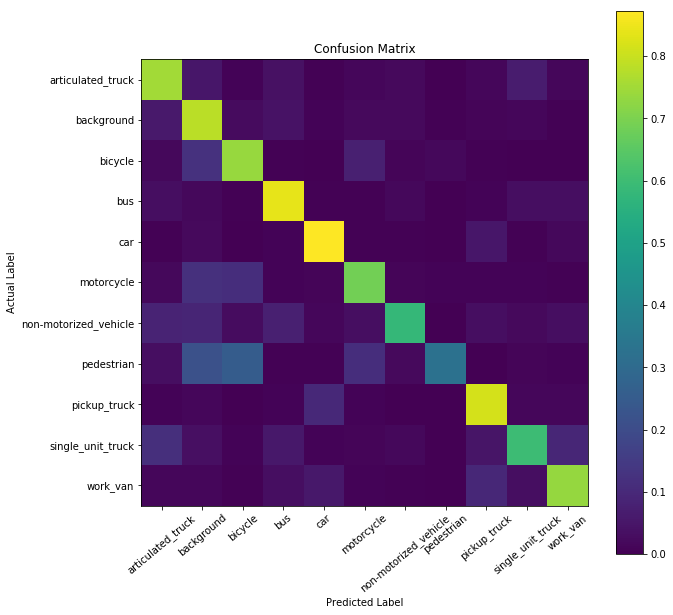

In [22]:
#Create ConfusionArrays
confusionPredArr = np.asarray(predictedArr).reshape(-1)
confusionActualArr = np.asarray(TestLabelArr).reshape(-1)

#Obtain non-normalize confusion matrix
confusionMat = confusion_matrix(confusionActualArr,confusionPredArr)

#Normalize confusion matrix across rows. 
confusionMat =  confusionMat.astype('float') / confusionMat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (10,10))
plt.imshow(confusionMat)
plt.colorbar()
title = "Confusion Matrix"
plt.title(title), plt.xlabel("Predicted Label"), plt.ylabel("Actual Label")
plt.xticks(np.arange(11),vehicleName,rotation=40), plt.yticks(np.arange(11),vehicleName)
plt.show()